# Homework of Week 7

In [883]:
import numpy as np
import matplotlib.pyplot as plt

In [884]:
# Versions
import qiskit
import qiskit_algorithms

print(f"Qiskit version {qiskit.__version__}")
print(f"Qiskit algorithms version {qiskit_algorithms.__version__}")


# Quantum Circuits!
from qiskit import QuantumCircuit

# General Imports
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Noisy simulations
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

# Running on a real quantum computer
from qiskit_ibm_runtime import QiskitRuntimeService

# Run time-evolution problems
from qiskit_algorithms.time_evolvers import TrotterQRTE, TimeEvolutionProblem

Qiskit version 1.3.2
Qiskit algorithms version 0.3.1


In [885]:
# Reconstruct the state from the Bloch vector
def state_from_bloch(bloch: list | np.ndarray) -> list:
    # Get angles
    theta = np.arccos(bloch[2])
    phi = np.arctan2(bloch[1], bloch[0])

    # Get the state
    a = np.cos(0.5 * theta)
    b = np.sin(0.5 * theta) * np.exp(1j * phi)

    return [a, b]


def bloch_from_state(state: list | np.ndarray) -> list:
    # Get phases
    phi0 = np.angle(state[0])
    phi1 = np.angle(state[1])

    # Get angles
    theta = 2 * np.arccos(np.abs(state[0]))
    phi = phi1 - phi0

    return [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]


# Get the density matrix for some Bloch vector
def density_from_bloch(bloch: list | np.ndarray) -> np.ndarray:
    # Pauli matrices
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])
    
    # Construct the density matrix
    rho = 0.5 * (I + bloch[0]*X + bloch[1]*Y + bloch[2]*Z)
    return rho


In [886]:
def aersim(qc: QuantumCircuit, shots: int = 1024, noise: None | NoiseModel = None) -> dict:
    # Create noisy simulator backend
    if noise:
        sim = AerSimulator(noise_model=noise)
    else:
        sim = AerSimulator()
    
    # Transpile circuit for noisy basis gates
    passmanager = generate_preset_pass_manager(
        optimization_level=3, backend=sim
    )
    qc = passmanager.run(qc)

    # Run
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    return counts

In [887]:
from scipy.linalg import sqrtm

# Computes the Uhlmann fidelity between two density matrices
def uhlmann_fidelity(rho: np.ndarray, sigma: np.ndarray):

    # Check dimensions
    if rho.shape != sigma.shape:
        raise ValueError("Density matrices must have the same dimensions.")

    # Compute square root of rho
    sqrt_rho = sqrtm(rho)

    # Compute the intermediate matrix: sqrt(rho) * sigma * sqrt(rho)
    product = sqrt_rho @ sigma @ sqrt_rho

    # Take matrix square root of the product
    sqrt_product = sqrtm(product)

    # Take trace and square the result to get fidelity
    fidelity = np.real(np.trace(sqrt_product)) ** 2

    return fidelity

# Quantum State Tomography

In [888]:
# This paper, section II B - https://arxiv.org/pdf/1407.4759
def inversion(n0: list[int], n1: list[int]) -> np.ndarray:
    nx0, ny0, nz0 = n0
    nx1, ny1, nz1 = n1

    # Do the inversion
    rd = np.array([(nx0 - nx1) / (nx0 + nx1), (ny0 - ny1) / (ny0 + ny1), (nz0 - nz1) / (nz0 + nz1)])

    # We have that |Bloch vector| <= 1
    if (norm := np.linalg.norm(rd)) > 1:
        rd /= norm
    
    return rd


# This paper, section II B - https://arxiv.org/pdf/1407.4759
def inversion_physical(n0: list[int], n1: list[int]) -> np.ndarray:
    nx0, ny0, nz0 = n0
    nx1, ny1, nz1 = n1

    # Do the inversion
    rd = np.array([(nx0 - nx1) / (nx0 + nx1), (ny0 - ny1) / (ny0 + ny1), (nz0 - nz1) / (nz0 + nz1)])

    # We are only dealing with pure states, hence |Bloch vector| = 1
    rd = rd / np.linalg.norm(rd)
    
    return rd


def qst_sim(qc: QuantumCircuit, qubit: int, shots: int = 1024, noise: None | NoiseModel = None) -> np.ndarray:

    # Measure the qubit in different basis (X, Y, Z basis respectively)
    n0 = [0, 0, 0]
    n1 = [0, 0, 0]
    for basis in range(3):
        qccopy = qc.copy()
        if basis == 0:
            qccopy.h(qubit)
        elif basis == 1:
            qccopy.sdg(qubit)
            qccopy.h(qubit)
        elif basis == 2:
            qccopy.id(qubit)
        
        qccopy.measure_all()

        # Run
        counts = aersim(qccopy, shots, noise)

        # Parse the output according to direction
        for item in counts.items():
            string, freq = item
            string = string[::-1]
            result = string[qubit]
            if int(result) == 0:
                n0[basis] += freq
            else:
                n1[basis] += freq
    
    return inversion(n0, n1)

# Teleportation Protocol

In [889]:
# Generate a random state
def rstate(unitary: bool = False) -> np.ndarray:
    # Chose the secret state for Alice
    theta = np.random.random() * np.pi
    phi = np.random.random() * (2 * np.pi)

    # Compute the coefficients
    a = np.cos(0.5 * theta)
    b = np.sin(0.5 * theta) * np.exp(1j * phi)

    if unitary:
        # Unitary matrix that makes that state
        return np.array([[a, -np.conj(b)], [b, np.conj(a)]])
    else:
        return np.array([a, b])

In [890]:
def teleportqc(inunitary: np.ndarray, measure: bool = True) -> QuantumCircuit:

    # Create the quantum circuit with 3 qubits and 1 classical bit
    if measure:
        qc = QuantumCircuit(3, 1)
    else:
        qc = QuantumCircuit(3)

    # Generate a secret state for Alice
    qc.unitary(Operator(inunitary), [0], label="Setup")

    # Step 0: Alice and Bob create an entangled pair in the Bell state 00
    qc.h(1)
    qc.cx(1, 2)
    qc.barrier()

    # Step 1: Alice applies a CNOT gate on  q1 controlled by q0 followed by a Hadamard (change to Bell basis)
    qc.cx(0, 1)
    qc.h(0)

    # Step 2: Alice applies a measurement to both her registers and sends the results to Bob
    # Step 3: Bob applies specific gates to his quantum register q2 based on the results he got
    qc.cx(1, 2)
    qc.cz(0, 2)

    # We do these two stepts at the same time by using controled gates!
    # This works because Bob has to apply X if Alice measured 1 on her second qubit and I otherwise and analogously for Z.
    if measure:
        # Verify if the teleportation worked by inverting the unitary transformation that generateb the secret state
        # but now applied to Bob's state, and if everything went correctly it should reverse the state back to |0>
        qc.unitary(Operator(np.conj(inunitary.T)), [2], label="Inverse")

        qc.barrier()
        qc.measure(2, 0)

    return qc

## Exercise 1

In [891]:
# Parameters
tests = 20
shots = 1000

for _ in range(tests):
    inunitary = rstate(unitary=True)
    qc = teleportqc(inunitary)
    counts = aersim(qc, shots=shots)

    if counts["0"] != shots:
        print(f"Test failed for state {inunitary[:, 0].T}")
        break
else:
    print("All tests passed!")

All tests passed!


## Exercise 2

In [ ]:
# Measure fidelity without noise
tests = 5
shots = 1000

for _ in range(tests):
    inunitary = rstate(unitary=True)
    instate = inunitary[:, 0]
    inbloch = bloch_from_state(np.array(instate))
    inrho = density_from_bloch(inbloch)

    qc = teleportqc(inunitary, measure=False)

    outbloch = qst_sim(qc, 2, shots=shots, noise=None)
    outrho = density_from_bloch(outbloch)

    fidelity = uhlmann_fidelity(inrho, outrho)
    if fidelity < 0.95:
        print(f"Low fidelity for state with Bloch vector: {inbloch}")
        break
else:
    print("Fidelity was above 0.95 for all states!")

Low fidelity for state with Bloch vector: [0.9085296339018915, -0.23532774495105457, -0.345245936657257]


We are going to use the **noise profile** of a real quantum computer.

In [896]:
# # Initiate connection
# TOKEN = "11cf40c4938ae90a81c46fcb5fba785e229c640a57f2b23d8e836f37f3de2d7abc2bc176c0742bbb3e85cf937774a89db0630913240faf5e82b2d63e9654ff16"
# service = QiskitRuntimeService(channel="ibm_quantum", token=TOKEN)

# # Choose a real quantum computer, which is not busy
# backend = service.least_busy(operational=True, simulator=False)
# print(f"{backend.name =}, {backend.num_qubits = }")

# # Get noise profile
# noise_real = NoiseModel.from_backend(backend)

backend.name ='ibm_brisbane', backend.num_qubits = 127


We immediately see that fidelity drops just by the addition of noise!

In [894]:
# Run qst for our teleportation protocol circuit
# Parameters
tests = 3
shots = 1000

for _ in range(tests):
    inunitary = rstate(unitary=True)
    inrho = density_from_bloch(bloch_from_state(np.array(inunitary[0, :])))
    
    qc = teleportqc(inunitary, measure=False)
    outrho = density_from_bloch(qst_sim(qc, 2, shots=shots, noise=noise_real))

    print(uhlmann_fidelity(inrho, outrho))

0.3596157502254631
0.19897129990027776
0.7724344248893114


### Question 1

We expect that the initial quantum gates will have to effects:
- Add noise into the system.
- Change the position of the Bloch vector.

The first effect will of course decrease the fidelity of the protocol, and we will explore the second one in question 2.

### Question 2

We can see that fidelity decreases a lot when the Bloch vector is pointing perpendicularly to the $z$ axis! This must be because the gates associated with rotations away from the axis are more noisy in the noise profile we used.

[]

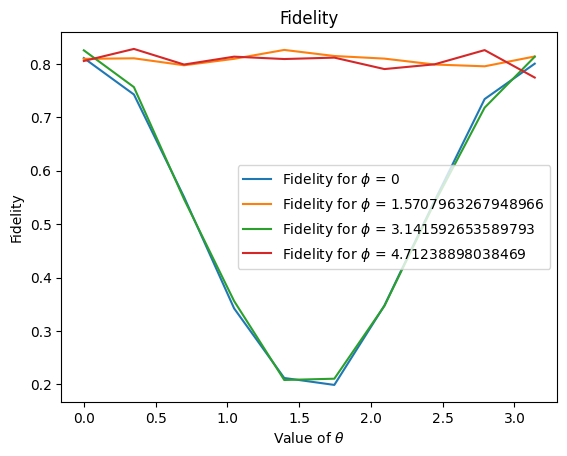

In [895]:
# Parameters
shots = 2000

# Create a grid of (theta, phi)
tt = np.linspace(0, np.pi, 10)
pp = [0, np.pi * 0.5, np.pi * 1.0, np.pi * 1.5]

plt.title(f"Fidelity")
for phi in pp:
    ff = []
    for theta in tt:
        # Get the state
        a = np.cos(0.5 * theta)
        b = np.sin(0.5 * theta) * np.exp(1j * phi)

        inunitary = np.array([[a, -np.conj(b)], [b, np.conj(a)]])
        inrho = density_from_bloch(bloch_from_state(np.array(inunitary[0, :])))
        
        qc = teleportqc(inunitary, measure=False)
        outrho = density_from_bloch(qst_sim(qc, 2, shots=shots, noise=noise_real))

        ff += [uhlmann_fidelity(inrho, outrho)]

    plt.plot(tt, ff, label=f"Fidelity for $\\phi$ = {phi}")

plt.xlabel("Value of $\\theta$")
plt.ylabel("Fidelity")
plt.legend()
plt.plot()